# GT Analysis: Cross Validation to specify activity category identification variable
In this notebook, we analyze the activity category identification with different variable (cross validation).

#### adding required packages

In [403]:
import pandas as pd
from scipy.stats import gaussian_kde
import time
import numpy as np
import pickle
from joblib import Parallel, delayed
import datetime as dt
import random
import geopandas as gpd
from pyproj import Proj, itransform
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib

### specifying the saving location 


In [362]:
savingLoc = "Y:/ZahraEftekhar/phase4/"

#### importing probability of each activity category for each OD zone
This file is the output of R after applying a hierarchical model on location zones.

In [363]:
locProbability = pd.read_csv("{a}locProbability_0.1.csv".format(a=savingLoc))
# locProbability = pd.read_csv("{a}locProbability.csv".format(a=savingLoc))

zeroR = pd.Series(0, index=locProbability.columns)
locProbability = locProbability.append(zeroR,ignore_index=True)
locProbability.loc[locProbability["home"]==0,["home","work","other"]]=0.33
locProbability.set_index("mzr_id",inplace=True)
locProbability = np.log(locProbability)
locProbability.reset_index(drop=False, inplace=True)
locProbability.drop('deviance',axis=1,inplace=True)
locProbability

,mzr_id,home,work,other
0,5012,-1.108663,-1.108663,-1.108663
1,5013,-0.905137,-1.352044,-1.088258
2,5026,-0.327786,-2.897553,-1.494660
3,5038,-1.108663,-1.108663,-1.108663
4,5076,-1.108663,-1.108663,-1.108663
...,...,...,...,...
110,7822,-1.108663,-1.108663,-1.108663
111,7823,-1.108663,-1.108663,-1.108663
112,7831,-0.693150,-1.458888,-1.318609
113,7832,-0.529557,-1.687205,-1.486787


### Location Type Identification

Now, we can use the files from the previous step to reconstruct the travel diaries. This include to first indentify the event type i.e., `stay` or `pass-by`, then identify the acticity type , i.e., `home`, `work` or `other`. 

In [364]:
#we time the process
startTime = time.time()

seed=101
random.seed(seed)
# building the zero OD Matrix based on the number of zones in the SHP
map_mzr = TAZmap()
map_mzr.set_map("{a}amsterdamMezuroZones.shp".format(a=savingLoc))
inputs = map_mzr.map.geometry
map_mzr.map
acts = ['home','work','other']
allActivity = pd.DataFrame()
for act in acts:

    with open('{a}{aa}_seed{s}.pickle'.format(aa = act,a=savingLoc,s=seed),
              'rb') as handle:
        activityFile = pickle.load( handle)
    points = list(zip([float(num) for num in (activityFile.x.values)],[float(num) for num in (activityFile.y.values)]))

    # projection 1:
    p1 = Proj(init='epsg:23031')
    # projection 2: 
    p2 = Proj(init='epsg:28992')
    ptsX = []
    ptsY = []
    for pt in itransform(p1,p2,points, always_xy=True): 
        ptsX = ptsX + [pt[0]]
        ptsY = ptsY + [pt[1]]
    activityFile = gpd.GeoDataFrame(activityFile, geometry=gpd.points_from_xy(ptsX,ptsY))
    activityFile = activityFile.set_crs(epsg=28992)
    activityFile = gpd.sjoin(activityFile, map_mzr.map,how = "left")
    activityFile.mzr_id = (np.nan_to_num((activityFile.mzr_id)))
    activityFile.drop(['index_right'],axis=1,inplace=True)
    activityFile.rename(columns={'home': 'Thome','work':'Twork','other':'Tother','activity?':'Tactivity?'},inplace=True)
    activityFile = activityFile.merge(locProbability,on="mzr_id",how="left")
    activityFile["actualAct"] = act
    activityFile.rename(columns={'home': 'Shome','work':'Swork','other':'Sother'},inplace=True)
    activityFile['Sactivity?'] = activityFile[['Shome','Swork','Sother']].idxmax(axis = 1).str[1:]
    for stAct in acts:
        activityFile['ST{aaa}'.format(aaa=stAct)] = activityFile["T{aaa}".format(aaa=stAct)]+(activityFile["S{aaa}".format(aaa=stAct)])
    activityFile['STactivity?'] = activityFile[['SThome','STwork','STother']].idxmax(axis = 1).str[2:]
    allActivity = allActivity.append(activityFile,ignore_index = True)
    
with open("{a}crossVal_activity_seed{b}".format(a=savingLoc,b=seed), 'wb') as handle:
    pickle.dump(activityFile, handle, protocol=pickle.HIGHEST_PROTOCOL)
print((time.time() - startTime)//60,'minutes')


C:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the

0.0 minutes


In [365]:
y_st = allActivity["STactivity?"].values
y_s = allActivity["Sactivity?"].values
y_t = allActivity["Tactivity?"].values
y_actu = allActivity["actualAct"].values

conST = pd.DataFrame(confusion_matrix(y_actu, y_st,labels=["home", "work", "other"]).T,
                     index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("ST:\n",conST)

conT = pd.DataFrame(confusion_matrix(y_actu, y_t,labels=["home", "work", "other"]).T,
                    index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("T:\n",conST)

conS = pd.DataFrame(confusion_matrix(y_actu, y_s,labels=["home", "work", "other"]).T,
                    index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("S:\n",conST)

with pd.ExcelWriter('{a}activityConfusion.xlsx'.format(a=savingLoc)) as writer:  
    conST.to_excel(writer, sheet_name='ST')
    conT.to_excel(writer, sheet_name='T')
    conS.to_excel(writer, sheet_name='S')


ST:
                  observed home  observed work  observed other
predicted home           22659            111             568
predicted work             223          12899             217
predicted other           4516            678           17182
T:
                  observed home  observed work  observed other
predicted home           22659            111             568
predicted work             223          12899             217
predicted other           4516            678           17182
S:
                  observed home  observed work  observed other
predicted home           22659            111             568
predicted work             223          12899             217
predicted other           4516            678           17182


home false-negative error based on start of the activity 


<Figure size 864x576 with 0 Axes>

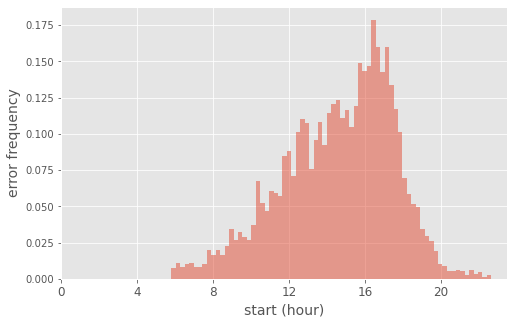

start of the activity other 


<Figure size 576x360 with 0 Axes>

<Figure size 864x576 with 0 Axes>

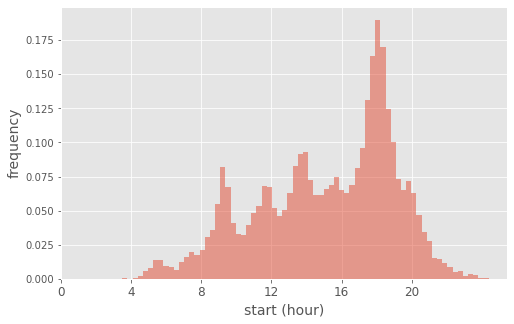

<Figure size 576x360 with 0 Axes>

In [469]:
# __________________ HOME PredictionError_start______________
kk =  allActivity[(allActivity["STactivity?"]!=allActivity["actualAct"]) & (allActivity.loc[:,"actualAct"]=="home")]
homeFalseNeg_start = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"start"]]
homeFalseNeg_start = pd.DataFrame(pd.to_numeric(homeFalseNeg_start)/3600)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# plt.figure()
plt.style.use('ggplot')
ax1 = (homeFalseNeg_start).plot(kind='hist', bins=72, density=True, alpha=0.5, label='prediction error of home activity', legend=False)
ax1.set_xlabel(u'start (hour)',fontsize=14)
print('home false-negative error based on start of the activity ')
ax1.set_ylabel('error frequency',fontsize=14)
plt.xticks((np.arange(0, 24, step=4)),fontsize=12)
plt.show()
plt.savefig("{a}homeFNs_start.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}homeFNs_start.png".format(a=savingLoc),dpi = 150)

# __________________ other_start______________
kk =  allActivity[(allActivity.loc[:,"actualAct"]=="other")]
other_start = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"start"]]
other_start = pd.DataFrame(pd.to_numeric(other_start)/3600)
# (other_start)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# # plt.figure()
plt.style.use('ggplot')
ax1 = (other_start).plot(kind='hist', bins=72, density=True, alpha=0.5, label='actual start of other activity', legend=False)
ax1.set_xlabel(u'start (hour)',fontsize=14)
print('start of the activity other ')
ax1.set_ylabel('frequency',fontsize=14)
plt.xticks((np.arange(0, 24, step=4)),fontsize=12)
plt.show()
plt.savefig("{a}other_start.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}other_start.png".format(a=savingLoc),dpi = 150)



home false-negative error based on duration of the activity 


<Figure size 864x576 with 0 Axes>

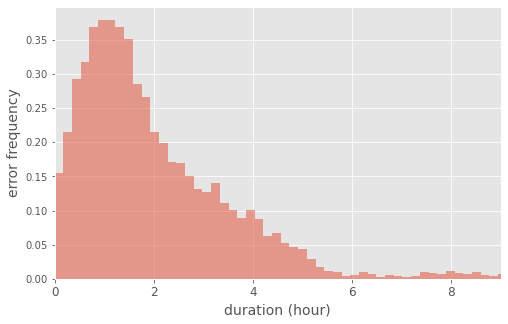

duration of the activity other 


<Figure size 576x360 with 0 Axes>

<Figure size 864x576 with 0 Axes>

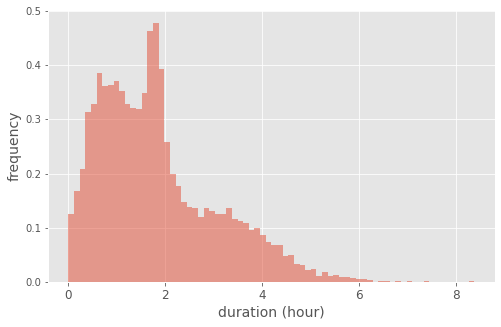

<Figure size 576x360 with 0 Axes>

In [473]:
# __________________ HOME PredictionError_duration______________
kk =  allActivity[(allActivity["STactivity?"]!=allActivity["actualAct"]) & (allActivity.loc[:,"actualAct"]=="home")]
homeFalseNeg_duration = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"duration"]]
homeFalseNeg_duration = pd.DataFrame(pd.to_numeric(homeFalseNeg_duration)/3600)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# plt.figure()
plt.style.use('ggplot')
ax1 = (homeFalseNeg_duration).plot(kind='hist', bins=72, density=True, alpha=0.5, label='prediction error of home activity', legend=False)
ax1.set_xlabel(u'duration (hour)',fontsize=14)
print('home false-negative error based on duration of the activity ')
ax1.set_ylabel('error frequency',fontsize=14)
plt.xticks((np.arange(0, 10, step=2)),fontsize=12)
plt.xlim((0,9))
plt.show()
plt.savefig("{a}homeFNs_duration.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}homeFNs_duration.png".format(a=savingLoc),dpi = 150)

# __________________ other_duration______________
kk =  allActivity[(allActivity.loc[:,"actualAct"]=="other")]
other_duration = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"duration"]]
other_duration = pd.DataFrame(pd.to_numeric(other_duration)/3600)
# (other_duration)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# # plt.figure()
plt.style.use('ggplot')
ax1 = (other_duration).plot(kind='hist', bins=72, density=True, alpha=0.5, label='actual duration of other activity', legend=False)
ax1.set_xlabel(u'duration (hour)',fontsize=14)
print('duration of the activity other ')
ax1.set_ylabel('frequency',fontsize=14)
plt.xticks((np.arange(0, 10, step=2)),fontsize=12)
plt.show()
plt.savefig("{a}other_duration.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}other_duration.png".format(a=savingLoc),dpi = 150)

In [474]:
print("overall accuracy when using only spatial variable: ",round(sum(allActivity["Sactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")
print("overall accuracy when using only temporal variables: ",round(sum(allActivity["Tactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")
print("overall accuracy when using both temporal and spatial variables: ",round(sum(allActivity["STactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")


overall accuracy when using only spatial variable:  47.92 %
overall accuracy when using only temporal variables:  89.69 %
overall accuracy when using both temporal and spatial variables:  89.31 %
